In [1]:
import jax
from jax.numpy.fft import fft, ifft
import jax.numpy as jnp
import matplotlib.pyplot as plt  
from jax import grad, vmap


import sys
root = '/home/emastr/github/phd/projects/vahid_project/'
sys.path.append('..')
sys.path.append(f'{root}src/')
sys.path.append(f'{root}util/')
sys.path.append(f'{root}data/')
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion

def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

# Use finite difference hessian for stepping.

I0000 00:00:1741791283.604370   16690 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


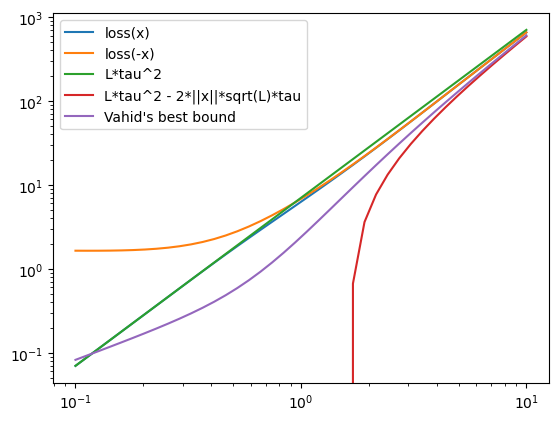

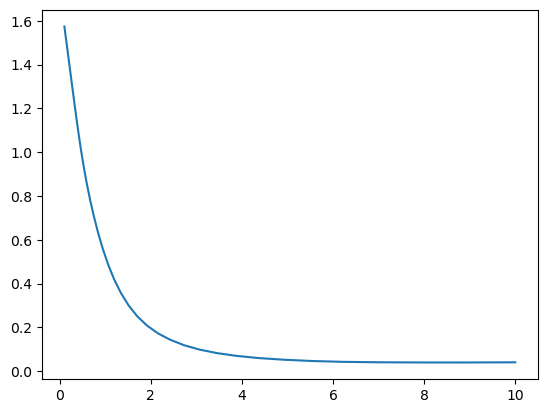

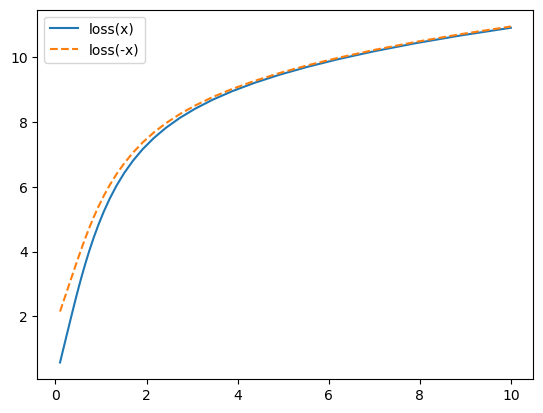

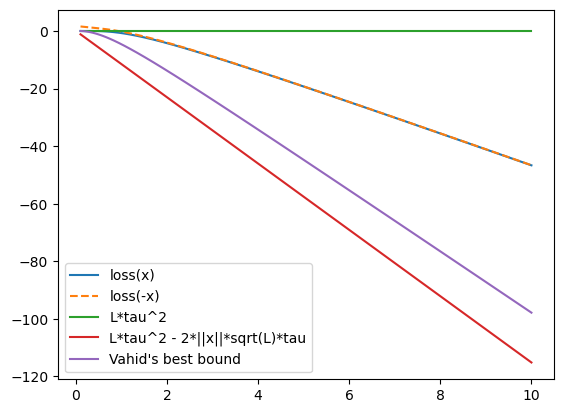

In [2]:
outer = lambda x, y: jnp.einsum('i,j->ij', x.conj(), y)
inner = lambda x, y: jnp.einsum('i,i->', x.conj(), y)
diff = lambda x: (x - jnp.roll(x, len(x)//10))/float(len(x)//10)*float(len(x))

Lhalf = 3
L = 2*Lhalf + 1
t = jnp.linspace(0, 2*jnp.pi, L+1)[:-1]
#f = lambda t: t == 0. #> jnp.pi
#f = lambda t: random.normal(random.PRNGKey(0), (L,))#t> jnp.pi
f = lambda t: jnp.exp(jnp.sin(t))
N = 500_000
x = f(t)
x = x - jnp.mean(x)

def loss(key, z, x, N, tau):
    y, noise, shift = get_samples(key, x, tau, N)
    yfft = fft(y, axis=1)
    zfft = fft(z)
    return loss_fft(zfft, yfft)

key = random.PRNGKey(22)
vmap_loss = vmap(lambda tau: loss(key, x, x, N, tau))
taus = jnp.logspace(-1, 1, 40)
losses = vmap_loss(taus)
losses2 = vmap(lambda tau: loss(key, -x, x, N, tau))(taus)

xnorm = jnp.linalg.norm(x)
const = 1.0
q_trend = L*taus**2
l_trend = -const * xnorm * L**0.5 * taus
tau_bound = lambda tau: (xnorm - jnp.sqrt(xnorm**2 + L*tau**2))**2 + xnorm*tau/jnp.sqrt(L)


plt.plot(taus, losses, label="loss(x)")
plt.plot(taus, losses2, label="loss(-x)")
plt.plot(taus, L*taus**2, label="L*tau^2")
plt.plot(taus, L*taus**2 - 2*xnorm*jnp.sqrt(L)*taus,  label="L*tau^2 - 2*||x||*sqrt(L)*tau")
plt.plot(taus, tau_bound(taus), label="Vahid's best bound")
#plt.plot(taus, q_trend + l_trend, label="quadratic + linear bound")
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.figure()
plt.plot(taus, (losses2 - losses), label="loss(x) - loss(-x)")
#plt.xscale("log")
#plt.yscale("log")


plt.figure()
plt.plot(taus, (losses - q_trend - l_trend), label="loss(x)")
plt.plot(taus, (losses2 - q_trend - l_trend), '--', label="loss(-x)")
#plt.plot(taus, q_trend - q_trend - l_trend, label="L*tau^2")
#plt.plot(taus, q_trend -2*xnorm*jnp.sqrt(L)*taus - q_trend - l_trend,  label="L*tau^2 - 2*||x||*sqrt(L)*tau")
#plt.plot(taus, tau_bound(taus)-q_trend-l_trend, label="Vahid's best bound")
plt.legend()


plt.figure()
plt.plot(taus, losses - L*taus**2, label="loss(x)")
plt.plot(taus, losses2 - L*taus**2, '--', label="loss(-x)")
plt.plot(taus, jnp.zeros_like(taus), label="L*tau^2")
plt.plot(taus, -2*xnorm*jnp.sqrt(L)*taus,  label="L*tau^2 - 2*||x||*sqrt(L)*tau")
plt.plot(taus, tau_bound(taus)-L*taus**2, label="Vahid's best bound")
plt.legend()
